# 1. openAPI 이용해서 데이터 읽기

공공데이터포털에서 제공하는 openAPI를 사용하여 2020.01.20~2021.08 까지의 시도별 코로나 발생현황를 알아본다.

## 1.1 알아야할 정보

### 시도별 발생동향 시각화 확인 가능
> http://ncov.mohw.go.kr/bdBoardList_Real.do?brdId=1&brdGubun=13&ncvContSeq=&contSeq=&board_id=&gubun=

</br>

### 보건복지부 코로나19시,도발생 현황 조회 소개 

> 코로나19감염증으로 인한 시.도별 신규확진자, 신규사망자, 격리중인환자수, 격리해제환자수등에 대한 현황자료



### 요청 메시지 명세
항목구분 : 필수(1), 옵션(0)


---
* serviceKey: (URL Encode)	공공데이터포털에서 발급받은 인증키 (1)
* numOfRows	: 한 페이지 결과 수 (1)
* pageNo	페이지 번호	4	(1)
* startCreate_dt:	검색할 생성일 범위의 시작 (0)
* endCreateDt: 검색할 생성일 범위의 종료(0)




### 응답 메시지 명세

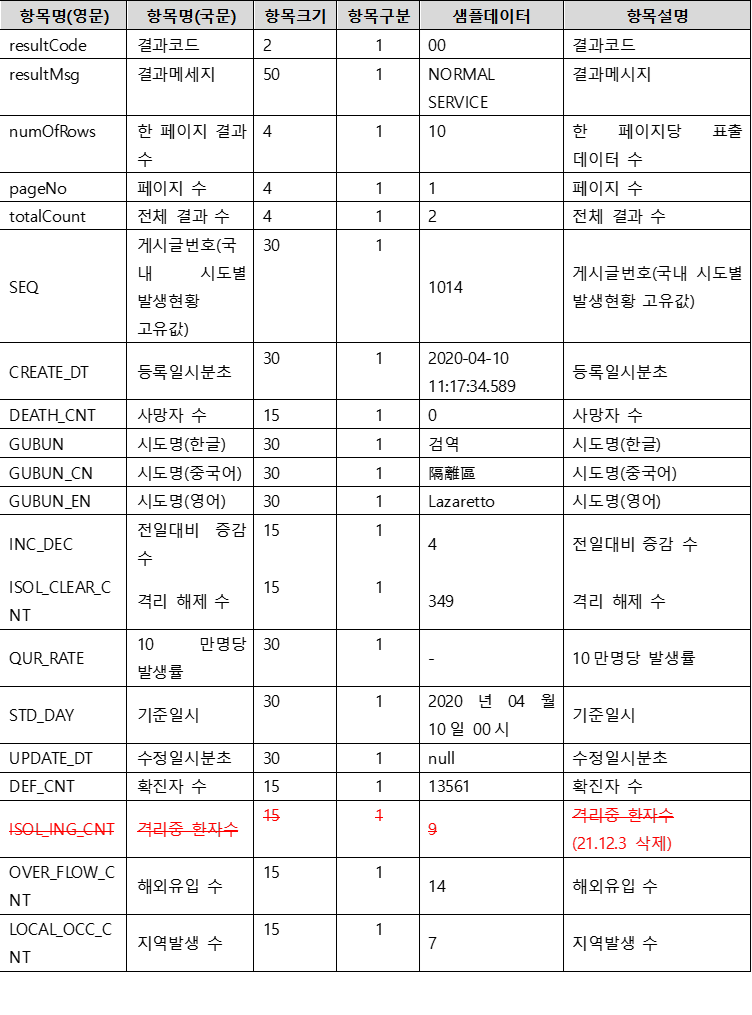

## 1.2 데이터 요청하기

In [26]:
import requests, lxml
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

**⚠ ERROR : IOPub data rate exceeded.** </br>
An IOPub error usually occurs when you try to print a large amount of data to the console. Check your print statements - if you're trying to print a file that exceeds 10MB, its likely that this caused the error. Try to read smaller portions of the file/data.
</br></br>
테스트는 작게 print해서 보고 전체 결과를 보고싶다면 postman등을 이용하자.

In [27]:
#url에 serviceKey까지 넣어야 'SERVICE_KEY_IS_NOT_REGISTERED_ERROR'가 발생하지 않는다.
url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey=BiRpoVSutytS0m4hAui5oVw5hElTkGPwCYkftxsOFFzkyWek%2FGAF1FBAbAcbbh2DhIfotaAfMIyIQQfjnB6tWA%3D%3D&pageNo=1'
params ={'pageNo' : '1', 
         'numOfRows' : '10', 
         'startCreateDt' : '20200120', 
         'endCreateDt' : '20210831' }

response = requests.get(url, params=params)
soup = BeautifulSoup(response.text, "lxml")

postman결과는 아래와 같다. 그러나 response의 항목명과 대소문자까지 일치하는 것은 아니다.

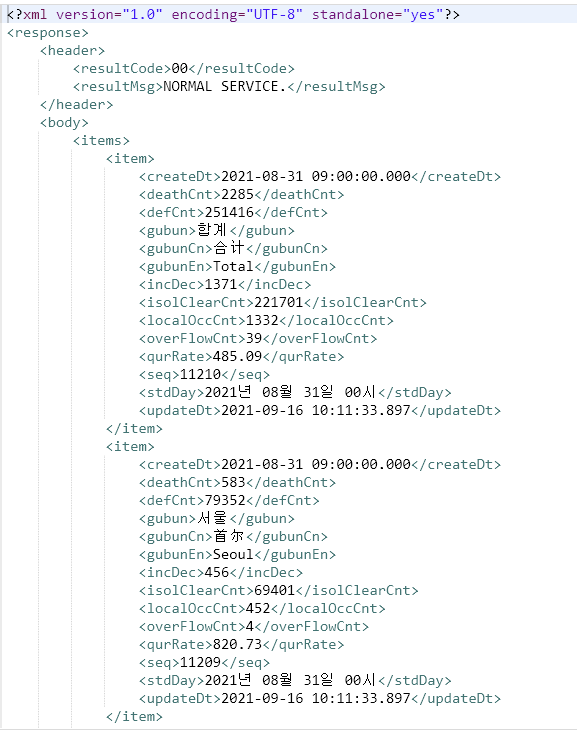

In [28]:
items = soup.find_all("item")
len(items)

11210

In [34]:
#20년 1월 20일부터 21년 8월 31일까지 잘 들어왔다.
print(items[0])
print(items[-1])

<item><createdt>2021-08-31 09:00:00.000</createdt><deathcnt>2285</deathcnt><defcnt>251416</defcnt><gubun>합계</gubun><gubuncn>合计</gubuncn><gubunen>Total</gubunen><incdec>1371</incdec><isolclearcnt>221701</isolclearcnt><localocccnt>1332</localocccnt><overflowcnt>39</overflowcnt><qurrate>485.09</qurrate><seq>11210</seq><stdday>2021년 08월 31일 00시</stdday><updatedt>2021-09-16 10:11:33.897</updatedt></item>
<item><createdt>2020-01-20 09:00:00.000</createdt><deathcnt>0</deathcnt><defcnt>0</defcnt><gubun>검역</gubun><gubuncn>隔離區</gubuncn><gubunen>Lazaretto</gubunen><incdec>0</incdec><isolclearcnt>0</isolclearcnt><localocccnt>0</localocccnt><overflowcnt>0</overflowcnt><qurrate>0.00</qurrate><seq>1</seq><stdday>2020년 01월 20일 00시</stdday><updatedt>2021-09-16 10:11:33.897</updatedt></item>


In [35]:
#items를 출력했을 때 보이는 항목을 써야 접근이 가능하다.
Si_Do = soup.find('gubun').get_text() #시도명(한글)
std_day = soup.find('stdday').get_text() #기준일시 (등록일시와는 다르다. 등록일시는 기준일시로부터 계산된 값을 데이터베이스에 등록한 시간이다.)
def_cnt = soup.find('defcnt').get_text() #확진자 수
inc_dec = soup.find('incdec').get_text() # 전일 대비 증감 수 
death_cnt = soup.find('deathcnt').get_text() #사망자 수 
qur_rate = soup.find('qurrate').get_text() #10만명당 발생률
isol_clear_cnt = soup.find('isolclearcnt').get_text()#격리해제 수
Si_Do, std_day, def_cnt, isol_clear_cnt

('합계', '2021년 08월 31일 00시', '251416', '221701')

In [77]:
std_day.replace("년 ","-").replace("월 ","-").replace("일","")

'2021-08-31 00시'

## 1.3 데이터프레임으로 만들기

### 1.3.1 데이터프레임에 저장
데이터를 살펴보면 
* 전일대비 증감수 : 신규확진자수 (음수가 존재하지 않음)
* 확진자수 : 누적값.

In [95]:
Corona_info = pd.DataFrame(columns=['기준일', '지역', '확진자수','전일대비증감수','10만명당 발생률','사망자수','격리해제수'])
Corona_info

Empty DataFrame
Columns: [기준일, 지역, 확진자수, 전일대비증감수, 10만명당 발생률, 사망자수, 격리해제수]
Index: []

In [96]:
for i in range(len(items)):
  Corona_info.loc[i] = [items[i].find('stdday').get_text().replace("년 ","-").replace("월 ","-").replace("일",""), 
                        items[i].find('gubun').get_text(), 
                        items[i].find('defcnt').get_text(),
                        items[i].find('incdec').get_text(),
                        items[i].find('qurrate').get_text(),
                        items[i].find('deathcnt').get_text(),
                        items[i].find('isolclearcnt').get_text()]

In [97]:
Corona_info

기준일  지역    확진자수 전일대비증감수 10만명당 발생률  사망자수   격리해제수
0      2021-08-31 00시  합계  251416    1371    485.09  2285  221701
1      2021-08-31 00시  서울   79352     456    820.73   583   69401
2      2021-08-31 00시  부산   11386      44    335.68   148   10272
3      2021-08-31 00시  대구   13646      51    564.27   227   12629
4      2021-08-31 00시  인천   11827      73    401.89    77   10492
...               ...  ..     ...     ...       ...   ...     ...
11205  2020-01-20 00시  전남       0       0      0.00     0       0
11206  2020-01-20 00시  경북       0       0      0.00     0       0
11207  2020-01-20 00시  경남       0       0      0.00     0       0
11208  2020-01-20 00시  제주       0       0      0.00     0       0
11209  2020-01-20 00시  검역       0       0      0.00     0       0

[11210 rows x 7 columns]

In [98]:
Corona_info.tail(50)

기준일  지역 확진자수 전일대비증감수 10만명당 발생률 사망자수 격리해제수
11160  2020-01-22 00시  울산    0       0      0.00    0     0
11161  2020-01-22 00시  세종    0       0      0.00    0     0
11162  2020-01-22 00시  경기    0       0      0.00    0     0
11163  2020-01-22 00시  강원    0       0      0.00    0     0
11164  2020-01-22 00시  충북    0       0      0.00    0     0
11165  2020-01-22 00시  충남    0       0      0.00    0     0
11166  2020-01-22 00시  전북    0       0      0.00    0     0
11167  2020-01-22 00시  전남    0       0      0.00    0     0
11168  2020-01-22 00시  경북    0       0      0.00    0     0
11169  2020-01-22 00시  경남    0       0      0.00    0     0
11170  2020-01-22 00시  제주    0       0      0.00    0     0
11171  2020-01-22 00시  검역    0       0      0.00    0     0
11172  2020-01-21 00시  합계    1       0      0.00    0     0
11173  2020-01-21 00시  서울    0       0      0.00    0     0
11174  2020-01-21 00시  부산    0       0      0.00    0     0
11175  2020-01-21 00시  대구    0       0      0.00    0     0
11176  2020-01-21 00시  인천    1       0      0.00    0     0
11177  2020-01-21 00시  광주    0       0      0.00    0     0
11178  2020-01-21 00시  대전    0       0      0.00    0     0
11179  2020-01-21 00시  울산    0       0      0.00    0     0
11180  2020-01-21 00시  세종    0       0      0.00    0     0
11181  2020-01-21 00시  경기    0       0      0.00    0     0
11182  2020-01-21 00시  강원    0       0      0.00    0     0
11183  2020-01-21 00시  충북    0       0      0.00    0     0
11184  2020-01-21 00시  충남    0       0      0.00    0     0
11185  2020-01-21 00시  전북    0       0      0.00    0     0
11186  2020-01-21 00시  전남    0       0      0.00    0     0
11187  2020-01-21 00시  경북    0       0      0.00    0     0
11188  2020-01-21 00시  경남    0       0      0.00    0     0
11189  2020-01-21 00시  제주    0       0      0.00    0     0
11190  2020-01-21 00시  검역    0       0      0.00    0     0
11191  2020-01-20 00시  합계    1       0      0.00    0     0
11192  2020-01-20 00시  서울    0       0      0.00    0     0
11193  2020-01-20 00시  부산    0       0      0.00    0     0
11194  2020-01-20 00시  대구    0       0      0.00    0     0
11195  2020-01-20 00시  인천    1       0      0.00    0     0
11196  2020-01-20 00시  광주    0       0      0.00    0     0
11197  2020-01-20 00시  대전    0       0      0.00    0     0
11198  2020-01-20 00시  울산    0       0      0.00    0     0
11199  2020-01-20 00시  세종    0       0      0.00    0     0
11200  2020-01-20 00시  경기    0       0      0.00    0     0
11201  2020-01-20 00시  강원    0       0      0.00    0     0
11202  2020-01-20 00시  충북    0       0      0.00    0     0
11203  2020-01-20 00시  충남    0       0      0.00    0     0
11204  2020-01-20 00시  전북    0       0      0.00    0     0
11205  2020-01-20 00시  전남    0       0      0.00    0     0
11206  2020-01-20 00시  경북    0       0      0.00    0     0
11207  2020-01-20 00시  경남    0       0      0.00    0     0
11208  2020-01-20 00시  제주    0       0      0.00    0     0
11209  2020-01-20 00시  검역    0       0      0.00    0     0

### 1.3.2 데이터 정제
결측치를 확인하고 string타입을 각자에 맞는 타입으로 바꾼다. 숫자로 인식되어야 describe등을 이용해서 이상치를 발견하기 쉽다.또한 타입을 변경하면서 isna()등으로 걸러지지 않았던 이상값(ex) "-"을 float으로 변경 불가능)을 발견할 수 있다.

In [99]:
Corona_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11210 entries, 0 to 11209
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   기준일        11210 non-null  object
 1   지역         11210 non-null  object
 2   확진자수       11210 non-null  object
 3   전일대비증감수    11210 non-null  object
 4   10만명당 발생률  11210 non-null  object
 5   사망자수       11210 non-null  object
 6   격리해제수      11210 non-null  object
dtypes: object(7)
memory usage: 700.6+ KB


In [107]:
Corona_info.isna().sum()

기준일          0
지역           0
확진자수         0
전일대비증감수      0
10만명당 발생률    0
사망자수         0
격리해제수        0
dtype: int64

In [101]:
#10만명당 발생률을 float타입으로 바꾸려고 했더니 string '-'을 float으로 바꿀 수 없다고 에러가 나서 발견. 나머지는 '-'값으로 채워진 값 없음.
Corona_info[Corona_info['10만명당 발생률']=='-']

기준일  지역  확진자수 전일대비증감수 10만명당 발생률 사망자수 격리해제수
4559  2021-01-04 00시  검역  2481      11         -    2  1681

In [119]:
#isna()에 관찰될 수 있는 결측값으로 바꾸기
Corona_info.loc[4559]['10만명당 발생률'] = np.NaN 

In [120]:
Corona_info.isna().sum()

기준일          0
지역           0
확진자수         0
전일대비증감수      0
10만명당 발생률    1
사망자수         0
격리해제수        0
dtype: int64

In [122]:
#타입변경
Corona_info = Corona_info.astype({'확진자수' : 'int', '전일대비증감수' : 'int', '사망자수': 'int',	'격리해제수':'int', '10만명당 발생률' : 'float' })
Corona_info['기준일'] = pd.to_datetime(Corona_info['기준일'], format="%Y-%m-%d %H시") #replace를 사용하지 않고 format을 년 월 일 이렇게 입력해도 상관 없다.

In [134]:
Corona_info #기준일에 시가 없어진 것은 모두 00시이기 때문.

기준일  지역    확진자수  전일대비증감수  10만명당 발생률  사망자수   격리해제수
0     2021-08-31  합계  251416     1371     485.09  2285  221701
1     2021-08-31  서울   79352      456     820.73   583   69401
2     2021-08-31  부산   11386       44     335.68   148   10272
3     2021-08-31  대구   13646       51     564.27   227   12629
4     2021-08-31  인천   11827       73     401.89    77   10492
...          ...  ..     ...      ...        ...   ...     ...
11205 2020-01-20  전남       0        0       0.00     0       0
11206 2020-01-20  경북       0        0       0.00     0       0
11207 2020-01-20  경남       0        0       0.00     0       0
11208 2020-01-20  제주       0        0       0.00     0       0
11209 2020-01-20  검역       0        0       0.00     0       0

[11210 rows x 7 columns]

In [123]:
Corona_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11210 entries, 0 to 11209
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   기준일        11210 non-null  datetime64[ns]
 1   지역         11210 non-null  object        
 2   확진자수       11210 non-null  int64         
 3   전일대비증감수    11210 non-null  int64         
 4   10만명당 발생률  11209 non-null  float64       
 5   사망자수       11210 non-null  int64         
 6   격리해제수      11210 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 1020.6+ KB


In [131]:
Corona_info['기준시'] = Corona_info['기준일'].dt.hour
Corona_info 

기준일  지역    확진자수  전일대비증감수  10만명당 발생률  사망자수   격리해제수  기준시
0     2021-08-31  합계  251416     1371     485.09  2285  221701    0
1     2021-08-31  서울   79352      456     820.73   583   69401    0
2     2021-08-31  부산   11386       44     335.68   148   10272    0
3     2021-08-31  대구   13646       51     564.27   227   12629    0
4     2021-08-31  인천   11827       73     401.89    77   10492    0
...          ...  ..     ...      ...        ...   ...     ...  ...
11205 2020-01-20  전남       0        0       0.00     0       0    0
11206 2020-01-20  경북       0        0       0.00     0       0    0
11207 2020-01-20  경남       0        0       0.00     0       0    0
11208 2020-01-20  제주       0        0       0.00     0       0    0
11209 2020-01-20  검역       0        0       0.00     0       0    0

[11210 rows x 8 columns]

In [132]:
Corona_info.describe() #기준시는 모두 0시 이므로 다시 제거.

확진자수       전일대비증감수  ...          격리해제수      기준시
count   11210.000000  11210.000000  ...   11210.000000  11210.0
mean     6755.934255     44.855397  ...    5966.569492      0.0
std     21890.797700    154.610802  ...   19614.720854      0.0
min         0.000000      0.000000  ...       0.000000      0.0
25%       124.000000      0.000000  ...      77.000000      0.0
50%      1039.000000      5.000000  ...     843.000000      0.0
75%      3685.750000     20.000000  ...    3271.000000      0.0
max    251416.000000   2221.000000  ...  221701.000000      0.0

[8 rows x 6 columns]

In [133]:
Corona_info = Corona_info.drop(['기준시'], axis=1)
Corona_info

기준일  지역    확진자수  전일대비증감수  10만명당 발생률  사망자수   격리해제수
0     2021-08-31  합계  251416     1371     485.09  2285  221701
1     2021-08-31  서울   79352      456     820.73   583   69401
2     2021-08-31  부산   11386       44     335.68   148   10272
3     2021-08-31  대구   13646       51     564.27   227   12629
4     2021-08-31  인천   11827       73     401.89    77   10492
...          ...  ..     ...      ...        ...   ...     ...
11205 2020-01-20  전남       0        0       0.00     0       0
11206 2020-01-20  경북       0        0       0.00     0       0
11207 2020-01-20  경남       0        0       0.00     0       0
11208 2020-01-20  제주       0        0       0.00     0       0
11209 2020-01-20  검역       0        0       0.00     0       0

[11210 rows x 7 columns]

In [139]:
Corona_info.rename(columns={'10만명당 발생률':'십만명당발생률'}, inplace= True) #DB에 넣을때 이름 에러 방지
Corona_info

기준일  지역    확진자수  전일대비증감수  십만명당발생률  사망자수   격리해제수
0     2021-08-31  합계  251416     1371   485.09  2285  221701
1     2021-08-31  서울   79352      456   820.73   583   69401
2     2021-08-31  부산   11386       44   335.68   148   10272
3     2021-08-31  대구   13646       51   564.27   227   12629
4     2021-08-31  인천   11827       73   401.89    77   10492
...          ...  ..     ...      ...      ...   ...     ...
11205 2020-01-20  전남       0        0     0.00     0       0
11206 2020-01-20  경북       0        0     0.00     0       0
11207 2020-01-20  경남       0        0     0.00     0       0
11208 2020-01-20  제주       0        0     0.00     0       0
11209 2020-01-20  검역       0        0     0.00     0       0

[11210 rows x 7 columns]

In [140]:
#일단 구글드라이브에 csv파일로 결과 백업
#Corona_info.to_csv("/content/drive/MyDrive/Corona_API.csv", index=False, encoding="utf-8-sig")

## 1.4 DB에 저장

In [135]:
import sqlite3

In [ ]:
# 만들어둔 csv파일 불러오기
# Corona_info=pd.read_csv("/content/drive/MyDrive/Corona_API.csv", parse_dates=['기준일'])
# Corona_info

In [ ]:
conn = sqlite3.connect("/content/gdrive/My Drive/NaplessRabbit.db")
cursor = conn.cursor()

for row in Corona_info.itertuples():
  cursor.execute('''INSERT INTO Corona_info (date, area1_City_Do, def_cnt
	, new_def, qur_rate) VALUES(?, ?, ?, ?, ?)''', 
	[row.기준일, row.지역, row.확진자수, row.전일대비증감수, row.십만명당발생률])

#Committing the changes
conn.commit()

#closing the database connection
conn.close()